# Iterative Construction of a Penalised Vine Structure
This notebook iteratively estimate the quantile.

#### Libraries

In [1]:
import openturns as ot
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

random_state = 123
np.random.seed(random_state)

#### Model function
This example consider the simple additive example.

In [2]:
def sum_func(x, a=None):
    """Additive example
    """        
    n, dim = x.shape
    if a is None:
        a = np.ones((dim, 1))

    if a.ndim == 1:
        a = a.reshape(-1, 1)
        assert a.shape[0] == dim, "Shape not good"
    elif a.ndim > 2:
        raise AttributeError('Dimension problem for constant a')
        
    return np.dot(x, a)

#### Dimension and margins
We first define the problem dimension and the margins

In [3]:
dim = 6
margins = [ot.Normal()]*dim

We chose the coefficients of the variables throught the additive function.

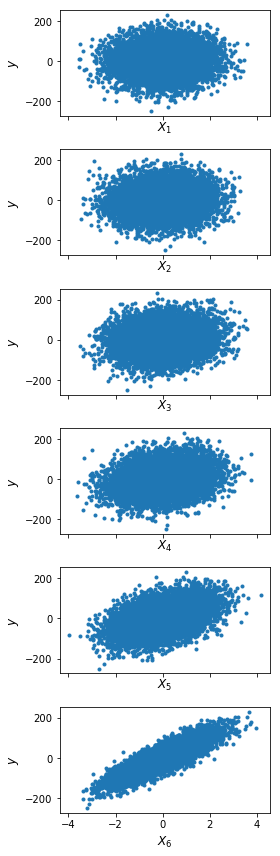

In [4]:
coeficients = np.logspace(0., 2., dim+1, endpoint=False)[1:]
# coeficients = np.ones((dim,))

n_plot = 10000
x = np.asarray(ot.ComposedDistribution(margins).getSample(n_plot))
y = sum_func(x, coeficients)

fig, axes = plt.subplots(dim, 1, sharex=True, sharey=True, figsize=(4, 2*dim))
for i in range(dim):
    ax = axes[i]
    ax.plot(x[:, i], y, '.')
    ax.set_xlabel(r'$X_%d$' % (i+1), fontsize=12)
    ax.set_ylabel(r'$y$', fontsize=12)
fig.tight_layout()

#### Copula families
We now consider only Gaussian dependencies for this example

In [5]:
families = np.zeros((dim, dim), dtype=int)
for i in range(1, dim):
    for j in range(i):
        families[i, j] = 1

## Estimations
We create an instance of the main class for conservative estimate, and we define a q_func object for the quantile as a quantity of interest

In [6]:
from dependence import ConservativeEstimate, quantile_func

quant_estimate = ConservativeEstimate(model_func=sum_func, margins=margins, families=families)

alpha = 0.05
q_func = quantile_func(alpha)

First, we compute the quantile at independence

In [7]:
n = 5000
indep_result = quant_estimate.independence(n_input_sample=n, q_func=q_func, random_state=random_state)

In [8]:
indep_result.compute_bootstrap(1000)
boot_std = indep_result.bootstrap_sample.std()
boot_mean = indep_result.bootstrap_sample.mean()
print('Quantile at independence: %.2f with a C.O.V at %.1f %%' % (boot_mean, abs(boot_std/boot_mean)*100.))

Quantile at independence: -4.09 with a C.O.V at 1.8 %


### Grid Search Approach
Firstly, we consider a grid search approach in order to compare the perfomance with the iterative algorithm.

In [9]:
K = 100
grid_type = 'lhs'
grid_result = quant_estimate.gridsearch_minimize(n_dep_param=K, n_input_sample=n, grid_type=grid_type, 
                                                 q_func=q_func, random_state=random_state)

In [10]:
min_result = grid_result.min_result
min_result.compute_bootstrap(1000)
boot_std = min_result.bootstrap_sample.std()
boot_mean = min_result.bootstrap_sample.mean()
print('Quantile at independence: %.2f with a C.O.V at %.1f %%' % (boot_mean, abs(boot_std/boot_mean)*100.))

Quantile at independence: -7.90 with a C.O.V at 2.1 %


In [11]:
print('Cost = %d' % (K*n))

Cost = 500000


In [12]:
if dim == 2:
    fig, ax = plt.subplots()
    ax.plot(grid_result.dep_params, grid_result.quantities)

### Iterative Approach
Now lets see how good we can be with the iterative appraoch.

In [13]:
def iterative_vine_minimize(quant_estimate, n, K_init, p_max, grid_type='lhs', 
                            q_func=np.var, n_remove_pairs=0, verbose=True):
    init_family = quant_estimate.families
    dim = quant_estimate.input_dim
    
    families = np.zeros((dim, dim))
    selected_pairs = []
    removed_pairs = []
    worst_quantities = []
    indiv_pair_quantities = {}

    cost = 0
    p = 0
    K = K_init
    
    while p < p_max:
        quantities = {}
        for i in range(1, dim):
            for j in range(i):
                if ((i, j) not in selected_pairs) and ((i, j) not in removed_pairs):
                    tmp_families = np.copy(families)
                    tmp_families[i, j] = init_family[i, j]
                    quant_estimate.families = tmp_families
                    if K is None:
                        quant_estimate.minmax_run(n)
                    else:
                        results = quant_estimate.gridsearch_minimize(n_dep_param=K, 
                                                                     n_input_sample=n, 
                                                                     grid_type=grid_type, 
                                                                     q_func=q_func)
                        cost += K*n
                        quantities[i, j] = results.min_quantity
                    if p == 0:
                        indiv_pair_quantities[i, j] = quantities[i, j]
                        
                    if verbose:
                        print('Worst quantile of {0} at {1}'.format(selected_pairs + [(i, j)], quantities[i, j]))

        sorted_quantities = sorted(quantities.items(), key=lambda x: x[1])
        if n_remove_pairs > 0:
            removed_pairs.extend([pair[0] for pair in sorted_quantities[-n_remove_pairs:]])
        
        selected_pair = sorted_quantities[0][0]
        i, j = selected_pair[0], selected_pair[1]
        families[i, j] = init_family[i, j]
        selected_pairs.append(selected_pair)
        worst_quantities.append(quantities[selected_pair])
        if verbose:
            print('p=%d, worst quantile at %.2f, cost = %d' % (p+1, quantities[selected_pair], cost))
            
        p += 1
        K = K_init*int(np.sqrt(p+1))
        
    return worst_quantities, selected_pairs, removed_pairs

In [14]:
p_max = 7
K = 10
verbose = True
grid_type = 'lhs'
quant_estimate = ConservativeEstimate(model_func=sum_func, margins=margins, families=families)
worst_quantities, selected_pairs, removed_pairs = iterative_vine_minimize(quant_estimate, n, K, 
                                                                          p_max, grid_type=grid_type, 
                                                                          q_func=q_func, n_remove_pairs=2)

Worst quantile of [(1, 0)] at -4.61263778942
Worst quantile of [(2, 0)] at -4.55745780519
Worst quantile of [(2, 1)] at -4.63392114921
Worst quantile of [(3, 0)] at -4.5893044184
Worst quantile of [(3, 1)] at -4.52793529981
Worst quantile of [(3, 2)] at -4.58497490473
Worst quantile of [(4, 0)] at -4.61731963669
Worst quantile of [(4, 1)] at -4.63613742687
Worst quantile of [(4, 2)] at -4.49358708929
Worst quantile of [(4, 3)] at -4.46344390623
Worst quantile of [(5, 0)] at -4.59810542808
Worst quantile of [(5, 1)] at -4.63543125624
Worst quantile of [(5, 2)] at -4.6304739643
Worst quantile of [(5, 3)] at -4.56581334475
Worst quantile of [(5, 4)] at -4.60455708931
p=1, worst quantile at -4.64, cost = 750000
Worst quantile of [(4, 1), (1, 0)] at -4.81898358009
Worst quantile of [(4, 1), (2, 0)] at -4.31745059137
Worst quantile of [(4, 1), (2, 1)] at -4.74648717
Worst quantile of [(4, 1), (3, 0)] at -4.63746539704
Worst quantile of [(4, 1), (3, 1)] at -4.79698513331
Worst quantile of [(4

IndexError: list index out of range

In [ ]:
%debug

> <ipython-input-13-7aad09329441>(43)iterative_vine_minimize()
     41             removed_pairs.extend([pair[0] for pair in sorted_quantities[-n_remove_pairs:]])
     42 
---> 43         selected_pair = sorted_quantities[0][0]
     44         i, j = selected_pair[0], selected_pair[1]
     45         families[i, j] = init_family[i, j]

ipdb> families
array([[ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  1.,  0.,  0.,  0.],
       [ 1.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.]])
